# Paraphrase Identification using HuggingFace on SageMaker - Background

Many customers today deal with use cases where identifying paraphrased text has business value. For example, by identifying sentence paraphrases, a text summarization system could remove redundant information. Another application is to identify plagiarized documents. Here, we will fine-tune a Hugging Face transformer on SageMaker to identify paraphrased sentence pairs in a few, simple steps.

# Setup and install libraries

We will begin by installing the necessary libraries, importing them into the development environment, selecting the appropriate IAM role and the Amazon S3 bucket.

Select the `conda_pytorch_p36` notebook kernel

Install the required libraries from Hugging Face - `transformers` and `datasets`. We'll also ensure that we have the updated version of `SageMaker Python SDK`

Documentation on [Installing Transformers](https://huggingface.co/docs/transformers/installation) and [Installing SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk/tree/master)

Note: if you see the following message after executing the pip install cell below, you can safely ignore it, it does not affect the packages and code in this notebook: "ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 1.0.61 requires nvidia-ml-py3, which is not installed.
spacy 3.0.6 requires pydantic<1.8.0,>=1.7.1, but you have pydantic 1.8.2 which is incompatible."

In [1]:
!pip --quiet install "sagemaker" "transformers==4.6.1" "datasets==1.6.2" --upgrade

In [2]:
import sagemaker.huggingface
import sagemaker
from datasets import load_dataset

In [3]:
sess = sagemaker.Session()
session_bucket = 'sts-sbert-paws-blog'

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=session_bucket)

print(f"SageMaker Role Arn: {role}")
print(f"SageMaker - Amazon S3 Bucket: {sess.default_bucket()}")
print(f"SageMaker Session Region: {sess.boto_region_name}")

SageMaker Role Arn: arn:aws:iam::410679667861:role/SageMakerRole
SageMaker - Amazon S3 Bucket: sts-sbert-paws-blog
SageMaker Session Region: us-east-1


# Import dataset

We will be using the `PAWS (Paraphrase Adversaries from Word Scrambling)` dataset. The final labled dataset contains pairs that are genreated from both word swapping and back translation methods. All pairs have human judgements on both paraphrasing and fluency and they are also split into `Train/Validation/Test` sections. The `Train` dataset contains a total of 49,401 sentence pairs, while the `Validation` and `Test` datasets contain a total of 8,000 sentence pairs each.

![image info](./img/PAWS-dataset-sample.png)

In [4]:
dataset_train, dataset_val, dataset_test = load_dataset("paws", "labeled_final", split=['train', 'validation', 'test'])

Dataset paws downloaded and prepared to /home/ec2-user/.cache/huggingface/datasets/paws/labeled_final/1.1.0/09d8fae989bb569009a8f5b879ccf2924d3e5cd55bfe2e89e6dab1c0b50ecd34. Subsequent calls will reuse this data.


# Understand Dataset

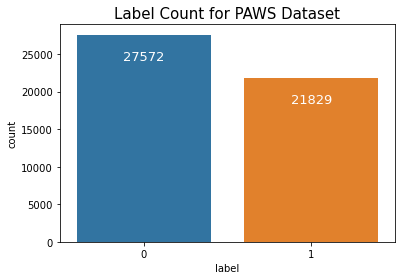

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = dataset_train.to_pandas()

ax = sns.countplot(x="label", data=df)
ax.set_title('Label Count for PAWS Dataset', fontsize=15)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=13)

We can see the dataset is slightly imbalanced, a few class imbalance strategies can be applied such as _oversampling_, _undersampling_, _SMOTE_, etc. For the purpose of demonstration, we will not implement these strategies and assume that we have a fairly balanced dataset.

In [12]:
df['label'].value_counts(normalize=True)

0    0.558126
1    0.441874
Name: label, dtype: float64

# Tokenize the text

In [45]:
from transformers import AutoTokenizer
tokenizer_and_model_name = 'roberta-large'

# Download tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_and_model_name)

# Tokenizer helper function
def tokenize(batch, max_len=128):
    return tokenizer(batch['sentence1'], batch['sentence2'], max_length=max_len, truncation=True)

dataset_train_tokenized = dataset_train.map(tokenize, batched=True, batch_size=len(dataset_train))
dataset_val_tokenized = dataset_val.map(tokenize, batched=True, batch_size=len(dataset_val))

In [46]:
dataset_train_tokenized, dataset_val_tokenized

(Dataset({
     features: ['attention_mask', 'id', 'input_ids', 'label', 'sentence1', 'sentence2'],
     num_rows: 49401
 }),
 Dataset({
     features: ['attention_mask', 'id', 'input_ids', 'label', 'sentence1', 'sentence2'],
     num_rows: 8000
 }),
 Dataset({
     features: ['attention_mask', 'id', 'input_ids', 'label', 'sentence1', 'sentence2'],
     num_rows: 8000
 }))

In [47]:
# convert tokenized datasets to PyTorch tensors
dataset_train_tokenized = dataset_train_tokenized.rename_column("label", "labels")
dataset_train_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

dataset_val_tokenized = dataset_val_tokenized.rename_column("label", "labels")
dataset_val_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Upload tokenized dataset to Amazon S3

After we processed the datasets we are going to use the new `FileSystem` [integration](https://huggingface.co/docs/datasets/filesystems.html) to upload our dataset to S3.

In [48]:
import botocore
from datasets.filesystems import S3FileSystem

s3 = S3FileSystem()
s3_prefix = 'sts-paws-datasets/paws-tokenized/' + tokenizer_and_model_name

# save train dataset to s3
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
dataset_train_tokenized.save_to_disk(training_input_path,fs=s3)

# save val dataset to s3
val_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/val'
dataset_val_tokenized.save_to_disk(val_input_path,fs=s3)

# Model Training: Amazon SageMaker - Hugging Face

BERT stands for Bidirectional Encoder Representations from Transformers, a transformer based model that uses Attention mechanism for learning contextual relationships among words of a sentence. With Hugging Face library, we can take a pre-trained BERT model that has learned contextual relationships from Wikipedia, books, other corpus, and fine tune the model on a specific set of paraphrase sentence pairs.

![](img/bert_transfer_learning.png)


This illustration is from Jacob D. et al (2019). The overall pre-training and fine-tuning procedure for BERT. Retrieved from https://arxiv.org/pdf/1810.04805.pdf

Other resources for learning more about transfer learning and BERT include - 1) [Recent Advances in Language Model Fine-tuning](https://ruder.io/recent-advances-lm-fine-tuning/) by Sebastian Ruder; 2) [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/) by Jay Alammar; 3) [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805); 4) [RoBERTa: A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/abs/1907.11692) and 5) [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)

# Model fine-tuning

Now that we are done with data preparation, we are ready to fine-tune our pre-trained roberta-large model on the task of identifying paraphrased sentences. We can leverage the HuggingFace Estimator class within SageMaker to initiate the fine-tuning process in a few simple steps.


Note: when fine-tuning HuggingFace transformers, ensure that the `transformers_version`, `pytorch_version` and `py_version` are aligned, as described [here](https://huggingface.co/docs/sagemaker/main)

In [34]:
hyperparameters = {'epochs': 4,
                   'train_batch_size': 16,
                   'model_name': tokenizer_and_model_name}

In [35]:
## Optional: View session bucket name
# f's3://{sess.default_bucket()}'

's3://sts-sbert-paws-blog'

In [36]:
metric_definitions=[
    {'Name': 'loss', 'Regex': "'loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_loss', 'Regex': "'eval_loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_accuracy', 'Regex': "'eval_accuracy': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_f1', 'Regex': "'eval_f1': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_precision', 'Regex': "'eval_precision': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_recall', 'Regex': "'eval_recall': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "'epoch': ([0-9]+(.|e\-)[0-9]+),?"}
]

In [37]:
from sagemaker.huggingface import HuggingFace

huggingface_estimator = HuggingFace(
                            entry_point='train.py',
                            source_dir='./scripts',
                            output_path=f's3://{sess.default_bucket()}',
                            base_job_name='huggingface-sdk-extension',
                            instance_type='ml.p3.8xlarge',
                            instance_count=1,
                            volume_size=100,
                            transformers_version='4.6.1',
                            pytorch_version='1.7.1',
                            py_version='py36',
                            role=role,
                            hyperparameters=hyperparameters,
                            metric_definitions=metric_definitions
                        )

We will be calling our `train.py` file store in `./scripts/train.py`, as shown below:

In [64]:
## Optional: View training script
# !pygmentize ./scripts/train.py

from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, set_seed
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import load_from_disk
import random
import logging
import sys
import argparse
import os
import torch


# Set seed for reproducibility
# https://huggingface.co/transformers/internal/trainer_utils.html?highlight=seed#transformers.set_seed
set_seed(42)


if __name__ == "__main__":

    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument("--epochs", type=int, default=3)
    parser.add_argument("--train_batch_size", type=int, default=32)
    parser.add_argument("--eval_batch_size", type=int, default=64)
    parser.add_argument("--warmup_steps", type=int, default=500)
    parser.add_argument("--model_name", type=str)
    parser.add_argument("--learning_rate", type=str, default=5e-5)
    parser

In [ ]:
import time

# Begin fine-tuning
huggingface_estimator.fit({'train': training_input_path, 'test': val_input_path}, 
                          wait=True, 
                          job_name='sm-sts-blog-{}'.format(int(time.time())))

2022-01-24 21:44:52 Starting - Starting the training job...
2022-01-24 21:44:54 Starting - Launching requested ML instancesProfilerReport-1643060692: InProgress
.........
2022-01-24 21:46:47 Starting - Preparing the instances for training.........
2022-01-24 21:48:04 Downloading - Downloading input data...
2022-01-24 21:48:46 Training - Downloading the training image...............
2022-01-24 21:51:25 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-24 21:51:16,086 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-24 21:51:16,129 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-24 21:51:17,545 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-01-24 21:51:18,085 sagemaker-training-toolkit INFO     Invoking user script
Traini

![](./img/sagemaker-training-job.png)

# Model Deployment

To deploy the trained model to an endpoint, we call the `deploy()` method on the HuggingFace estimator object.

In [66]:
predictor = huggingface_estimator.deploy(initial_instance_count=1,
                                         instance_type="ml.g4dn.xlarge", 
                                         endpoint_name="sts-sbert-paws")

---------!

**Optional: Alternativel, we can also load the fine-tuned model from s3, if one has been trained previously.**

In [ ]:
# TODO: comment out cells below after final review

In [81]:
# import boto3

# sm_client = boto3.client('sagemaker')
# bucket_name = 'sts-sbert-paws-blog'
# latest_sm_training_job_name = sm_client.list_training_jobs()['TrainingJobSummaries'][0]['TrainingJobName']

# S3_PATH_TRAINED_MODEL_FILE = 's3://' + bucket_name + '/' + latest_sm_training_job_name + '/output/model.tar.gz'

In [83]:
# # recreate the huggingface_model object

# from sagemaker.huggingface import HuggingFaceModel

# huggingface_model = HuggingFaceModel(
#     model_data=S3_PATH_TRAINED_MODEL_FILE,
#     role=role,
#     transformers_version='4.6.1',
#     pytorch_version='1.7.1',
#     py_version='py36',
# )

In [84]:
# predictor = huggingface_model.deploy(initial_instance_count=1,
#                                      instance_type='ml.g4dn.xlarge', 
#                                      endpoint_name='sts-sbert-paws')

--------!

Other scenarios to deploy a model to a SageMaker endpoint include - 1) from a model stored in the [Hugging Face Hub](https://huggingface.co/models) and 2) by using a custom inference container. For more information on these methods refer to [Announcing managed inference for Hugging Face models in Amazon SageMaker](https://aws.amazon.com/blogs/machine-learning/announcing-managed-inference-for-hugging-face-models-in-amazon-sagemaker/)

# Model Inference

Once the model is deployed, we can send observations from the unseen test dataset - `df_test` to the endpoint, to make predictions.

Let's select a few sentences from the test dataset and send it to the endpoint for predictions.

In [96]:
# Re-run this cell to see predictions on alternative sample test inputs

import random 

rand = random.randrange(0, 8000)

true_label = dataset_test[rand]['label']
sent_1 = dataset_test[rand]['sentence1']
sent_2 = dataset_test[rand]['sentence2']

sentence_pair = {"inputs": ['[CLS] ' + sent_1 + ' [SEP] ' + sent_2 + ' [SEP]']}

print('Sentence 1:', sent_1) 
print('Sentence 2:', sent_2)
print()
print('True Label:', true_label)
print('Predicted Label:', predictor.predict(sentence_pair)[0]['label'])
print('Prediction Confidence:', predictor.predict(sentence_pair)[0]['score'])

Sentence 1: Mark Twain ( 11 August 1798 – 24 March 1847 ) was the father of the author John Marshall Clemens .
Sentence 2: John Marshall Clemens ( August 11 , 1798 -- March 24 , 1847 ) was the father of the author Mark Twain .

True Label: 0
Predicted Label: LABEL_0
Prediction Confidence: 0.9666486382484436


# Model Evaluation

Let's apply the fine-tuned model on the whole unseen test set and evaluate the model's performance

In [87]:
print('Number of test set records:', len(dataset_test))

Number of test set records: 8000


In [88]:
from tqdm import tqdm

preds = []
labels = []

# Inference takes ~5 minutes for all test records using a fine-tuned roberta-large and ml.g4dn.xlarge instance

for i in tqdm(range(len(dataset_test))):
    true_label = dataset_test[i]['label']
    sent_1 = dataset_test[i]['sentence1']
    sent_2 = dataset_test[i]['sentence2']
    
    sentence_pair = {"inputs": ['[CLS] ' + sent_1 + ' [SEP] ' + sent_2 + ' [SEP]']}
    pred = predictor.predict(sentence_pair)
    
    labels.append(true_label)
    preds.append(int(pred[0]['label'].split('_')[1]))

100%|██████████| 8000/8000 [02:40<00:00, 50.00it/s]


In [90]:
from sklearn.metrics import classification_report

print('Endpoint Name:', predictor.endpoint_name)
class_names = ['paraphase', 'not paraphrase']
print(classification_report(labels, preds, target_names=class_names))

Endpoint Name: sts-sbert-paws-mpnet
                precision    recall  f1-score   support

     paraphase       0.93      0.92      0.93      4464
not paraphrase       0.90      0.92      0.91      3536

      accuracy                           0.92      8000
     macro avg       0.92      0.92      0.92      8000
  weighted avg       0.92      0.92      0.92      8000



From the test set scores above, we can see roberta-large has a combined f1-score of 93% and performs equally well across both classes.

# Cleanup

When we are done with the endpoint, we can delete it to save cost.

In [105]:
predictor.delete_model()
predictor.delete_endpoint()

# Additional Resources

1. [Use Hugging Face with Amazon SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/hugging-face.html)
2. [Hugging Face sample notebooks](https://github.com/huggingface/notebooks/tree/master/sagemaker)
3. [AWS Blog - AWS and Hugging Face collaborate to simplify and accelerate adoption of Natural Language Processing models](https://aws.amazon.com/blogs/machine-learning/aws-and-hugging-face-collaborate-to-simplify-and-accelerate-adoption-of-natural-language-processing-models/)
4. [AWS Blog - Announcing managed inference for Hugging Face models in Amazon SageMaker](https://aws.amazon.com/blogs/machine-learning/announcing-managed-inference-for-hugging-face-models-in-amazon-sagemaker/)
5. [The Partnership: Amazon SageMaker and Hugging Face](https://huggingface.co/blog/the-partnership-amazon-sagemaker-and-hugging-face)
6. Sarker A, Gonzalez G. Portable automatic text classification for adverse drug reaction detection via multi-corpus training. J Biomed Inform. 2015;53:196-207. doi:10.1016/j.jbi.2014.11.002
